# Modeling preparation time for order packing

This project focuses on training models to predict the time it takes to pack an order in a restaurant's kitchen. 
Our main goal is to predict the duration between finishing packing an order and the order coming out of the oven. To accomplish this, we will use various statistical models. We are doing it in order to optimize the order packing time, which influences the efficiency of the restaurant's operations.

Since this project is a home assignment, certain assumptions might be necessary to address gaps in understanding the data's underlying process.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.table import Cell

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split

In [2]:
# import the datasets
Canada_ovenSeconds_per_store = pd.read_csv('Canada-ovenSeconds-per-store.csv')
orders_truncated = pd.read_csv('orders_truncated.csv', index_col=0).reset_index(drop=True)

orders_truncated['reached_makeline_utc'] = pd.to_datetime(orders_truncated['reached_makeline_utc'])
orders_truncated['oven_time'] = pd.to_datetime(orders_truncated['oven_time'])
orders_truncated['ready_utc'] = pd.to_datetime(orders_truncated['ready_utc'])

orders_truncated = orders_truncated.merge(Canada_ovenSeconds_per_store, left_on=['merchant_id'], right_on=['StoreNo'], how='left')
orders_truncated[:5]

,dt_order_id,order_type,makeline_deviation,dispatch_deviation,merchant_id,reached_makeline_utc,oven_time,ready_utc,count_of_items,batch_size,id,StoreNo,OvenSeconds
0,221115000244,Delivery,0,0,34901,2022-11-15 23:38:05,2022-11-15 23:39:13,2022-11-15 23:56:22,11,1.0,23347680,34901,465
1,221115000237,Delivery,0,0,34904,2022-11-15 23:34:55,2022-11-15 23:35:55,2022-11-15 23:46:23,2,1.0,23347679,34904,465
2,221115000243,Delivery,0,0,34901,2022-11-15 23:23:15,2022-11-15 23:23:39,2022-11-15 23:30:29,1,1.0,23347678,34901,465
3,221115000236,Delivery,0,0,34904,2022-11-15 23:31:05,2022-11-15 23:32:27,2022-11-15 23:42:04,3,1.0,23347677,34904,465
4,221115000242,Delivery,0,0,34901,2022-11-15 23:18:59,2022-11-15 23:20:43,2022-11-15 23:30:23,3,1.0,23347676,34901,465


### Feature extraction

In our dataset, almost one third of the observations have negative values in the preparation time. We chose to drop these observations from our analysis because there are some uncertainties in the data that prevent us from accurately interpreting these negative values.

1. If we assume that orders with negative preparation time did not require oven preparation, the resulting target variable would not measure the same concept. 
2. Similarly, if we assume that if 'makeline_deviation' equals 1, then the employer removed the food from the oven before the defined 'OvenSeconds' in the store. However, this would again not accurately measure the same thing, as 'makeline_deviation' can also indicate other actions, and we do not have enough information about these actions.

Therefore, we have decided to stick with the definition of the target variable as given in the instruction file, but it is important to note that we could explore other solutions, such as measuring all observations from the time the order appeared on the kitchen screen, in the future. It would be useful to have a better understanding of the optimization algorithm to determine the best approach for this.

We also assume that it takes at least 1 second to take the food outside the oven. We also have just two observations of 'Dine-In' order type. We do not want to model it and it will already drop out during the following cleaning process.

In [3]:
# extract the date and hour components
orders_truncated['oven_time_date'] = orders_truncated['reached_makeline_utc'].dt.date
orders_truncated['oven_time_hour'] = orders_truncated['reached_makeline_utc'].dt.hour

# creating target variable
orders_truncated['oven_and_preparation_time'] = (orders_truncated['ready_utc']-orders_truncated['oven_time']).dt.total_seconds()
orders_truncated['preparation_time'] = orders_truncated['oven_and_preparation_time'] - orders_truncated['OvenSeconds']

# drop non-positive values
orders_truncated = orders_truncated[orders_truncated['preparation_time']>0]

# impute missing values
orders_truncated['batch_size'] = orders_truncated['batch_size'].fillna(orders_truncated['batch_size'].median())
orders_truncated[:5]

,dt_order_id,order_type,makeline_deviation,dispatch_deviation,merchant_id,reached_makeline_utc,oven_time,ready_utc,count_of_items,batch_size,id,StoreNo,OvenSeconds,oven_time_date,oven_time_hour,oven_and_preparation_time,preparation_time
0,221115000244,Delivery,0,0,34901,2022-11-15 23:38:05,2022-11-15 23:39:13,2022-11-15 23:56:22,11,1.0,23347680,34901,465,2022-11-15,23,1029.0,564.0
1,221115000237,Delivery,0,0,34904,2022-11-15 23:34:55,2022-11-15 23:35:55,2022-11-15 23:46:23,2,1.0,23347679,34904,465,2022-11-15,23,628.0,163.0
3,221115000236,Delivery,0,0,34904,2022-11-15 23:31:05,2022-11-15 23:32:27,2022-11-15 23:42:04,3,1.0,23347677,34904,465,2022-11-15,23,577.0,112.0
4,221115000242,Delivery,0,0,34901,2022-11-15 23:18:59,2022-11-15 23:20:43,2022-11-15 23:30:23,3,1.0,23347676,34901,465,2022-11-15,23,580.0,115.0
5,221115000235,Delivery,0,0,34904,2022-11-15 23:18:05,2022-11-15 23:20:36,2022-11-15 23:29:49,1,1.0,23347675,34904,465,2022-11-15,23,553.0,88.0


### Exploratory data analysis (EDA)

In [4]:
# basic statistical summary
print(orders_truncated[['makeline_deviation','dispatch_deviation','count_of_items','batch_size','OvenSeconds','preparation_time']].describe())

       makeline_deviation  dispatch_deviation  count_of_items     batch_size  \
count       789943.000000       789943.000000   789943.000000  789943.000000   
mean             0.042412            0.025841        2.541097       1.323012   
std              0.201527            0.158661        2.402255       4.435771   
min              0.000000            0.000000        1.000000       1.000000   
25%              0.000000            0.000000        1.000000       1.000000   
50%              0.000000            0.000000        2.000000       1.000000   
75%              0.000000            0.000000        3.000000       1.000000   
max              1.000000            1.000000      386.000000     257.000000   

         OvenSeconds  preparation_time  
count  789943.000000      7.899430e+05  
mean      466.691401      1.548753e+02  
std        20.025310      2.844108e+02  
min       390.000000      5.684342e-14  
25%       465.000000      5.400000e+01  
50%       465.000000      1.10000

Text(0.5, 1.0, 'Correlation Matrix')

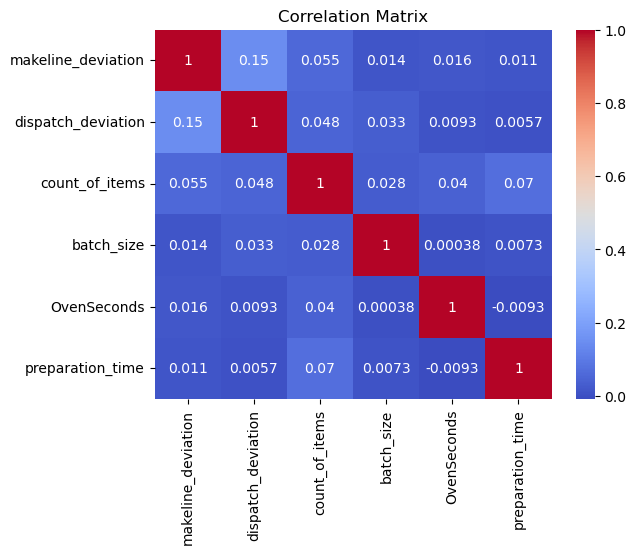

In [5]:
# correlation matrix
corr_matrix = orders_truncated[['makeline_deviation','dispatch_deviation','count_of_items','batch_size','OvenSeconds','preparation_time']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

Text(0.5, 1.0, 'Preparation time (seconds) by order type')

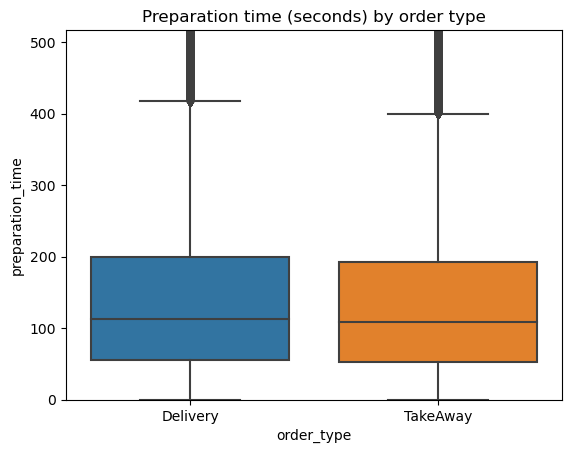

In [6]:
# boxplot of preparation time by order type
qmin, qmax = orders_truncated['preparation_time'].quantile([0.00, 0.97])
sns.boxplot(data=orders_truncated, x='order_type', y='preparation_time')
plt.ylim(qmin, qmax)
plt.title('Preparation time (seconds) by order type')

Text(0.5, 1.0, 'Preparation time by count of items')

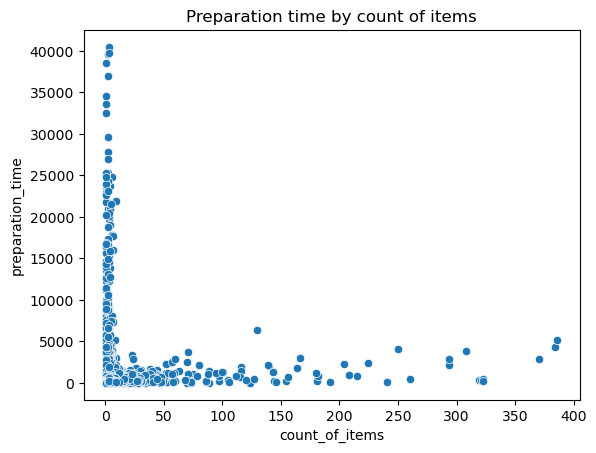

In [7]:
# preparation time and count of items
sns.scatterplot(data=orders_truncated, x='count_of_items', y='preparation_time')
plt.title('Preparation time by count of items')

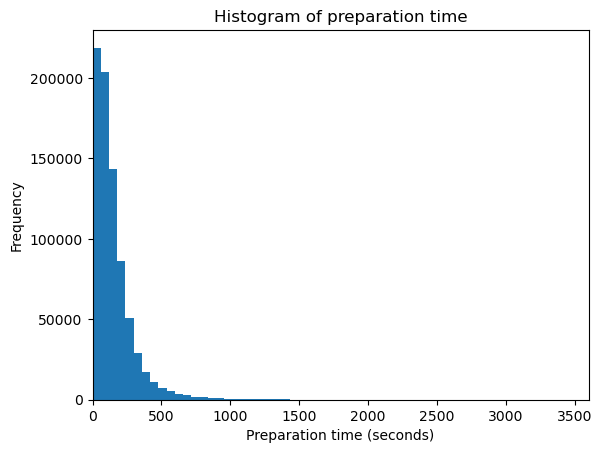

In [8]:
# histogram of preparation time
plt.hist(orders_truncated[orders_truncated['preparation_time']<3600]['preparation_time'], bins=60)
plt.xlim(0,3600)
plt.xlabel('Preparation time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of preparation time')
plt.show()

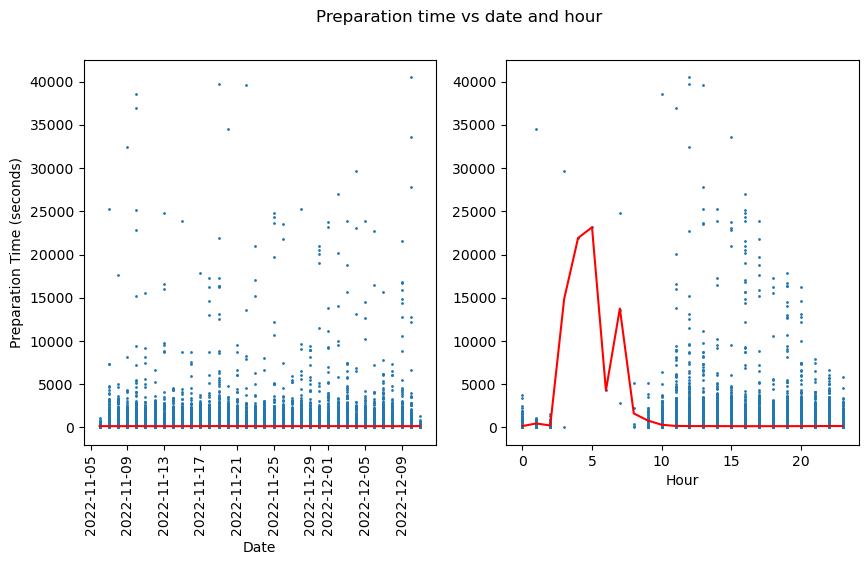

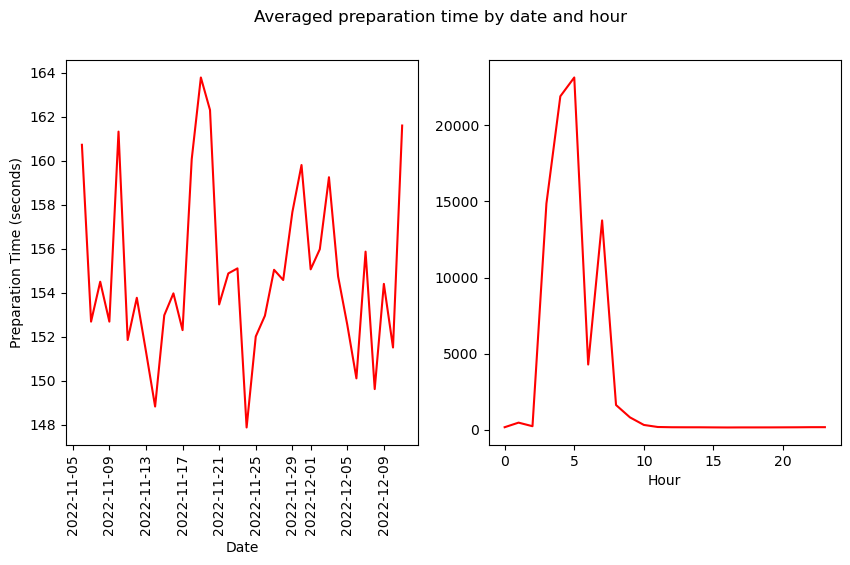

In [9]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
# create a scatter plot of preparation time vs date
ax1.scatter(orders_truncated['oven_time_date'], orders_truncated['preparation_time'], s=1)
ax1.plot(orders_truncated.groupby('oven_time_date')['preparation_time'].mean(), color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Preparation Time (seconds)')
ax1.tick_params(axis='x',rotation=90)
# Create a scatter plot of preparation time vs hour
ax2.scatter(orders_truncated['oven_time_hour'], orders_truncated['preparation_time'], s=1)
ax2.plot(orders_truncated.groupby('oven_time_hour')['preparation_time'].mean(), color='red')
ax2.set_xlabel('Hour')
fig.suptitle('Preparation time vs date and hour')
plt.show()


# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
# create a scatter plot of preparation time vs date
ax1.plot(orders_truncated.groupby('oven_time_date')['preparation_time'].mean(), color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Preparation Time (seconds)')
ax1.tick_params(axis='x',rotation=90)
# create a scatter plot of preparation time vs hour
ax2.plot(orders_truncated.groupby('oven_time_hour')['preparation_time'].mean(), color='red')
ax2.set_xlabel('Hour')
fig.suptitle('Averaged preparation time by date and hour')
plt.show()

To conclude from the EDA phase, we see that:

- the averaged preparation time is approximately 100 seconds
- the number of items in the order correlate stronger with preparation time
- the preparation time for delivery is slightly higher than in take-away
- the data is highly skewed so we might consider to use log transformation
- differences in the preparation time by dates and time in the day. Therefore we will take it into account in our models

We choose to use the following models to predict the preparation time accurately:

#### Fixed effect model

Fixed effect model allows us to control for the fixed effects of stores, dates, time in the day and order types. For example, by including a dummy variable for each store, we can estimate the effect of other independent variables on the preparation time while holding the effect of the store constant. This can be useful since we suspect that there are systematic differences in preparation time between stores that are not captured by other independent variables.

In [10]:
# convert categorical variables to dummies
fixed_effects = ['order_type', 'oven_time_date', 'oven_time_hour','merchant_id']
categorial_X  = pd.get_dummies(orders_truncated, columns=fixed_effects, drop_first=True)
X = categorial_X.drop(columns=['dt_order_id', 'reached_makeline_utc','oven_time','ready_utc','id','StoreNo','oven_and_preparation_time'])

# train-test split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [11]:
# define the model formula
model_formula = 'preparation_time ~ count_of_items + count_of_items**2 + batch_size + makeline_deviation + dispatch_deviation'
for col in X.columns:
    if col.startswith('order_type_') or col.startswith('oven_time_date_') or col.startswith('oven_time_hour_') or col.startswith('merchant_id_'):
        model_formula += ' + Q("' + col + '")'
# fit the fixed effect model
fixedlm_model = sm.formula.ols(model_formula, data=X_train)
fixedlm_model_fit = fixedlm_model.fit()

# make predictions
y_train_pred = fixedlm_model_fit.predict(X_train)
y_test_pred = fixedlm_model_fit.predict(X_test)

# calculate the RMSE
rmse_train =  np.sqrt(mean_squared_error(X_train['preparation_time'], y_train_pred))
rmse_test = np.sqrt(mean_squared_error(X_test['preparation_time'], y_test_pred))

print('RMSE of train data:', rmse_train)
print('RMSE of test data:', rmse_test)

# feature importance 
coeff_table = pd.DataFrame(fixedlm_model_fit.summary().tables[1])
coeff_table = coeff_table.rename(columns=coeff_table.iloc[0]).drop(coeff_table.index[0])
coeff_table.columns = [str(cell) for cell in coeff_table.iloc[0].index]
coeff_table = coeff_table.astype({'coef': 'str','P>|t|': 'str'}).astype({'coef': 'float','P>|t|': 'float'})
coeff_table['abs_coef'] = abs(coeff_table['coef'])
coeff_table = coeff_table.sort_values('abs_coef', ascending=False)
coeff_table[coeff_table['P>|t|']<=0.1][:10]

RMSE of train data: 276.7878610301244
RMSE of test data: 268.9404178520906


,,coef,std err,t,P>|t|,[0.025,0.975],abs_coef
46,"Q(""oven_time_hour_5"")",22870.0000,277.095,82.540,0.00,2.23e+04,2.34e+04,22870.0000
45,"Q(""oven_time_hour_4"")",21730.0000,277.144,78.423,0.00,2.12e+04,2.23e+04,21730.0000
48,"Q(""oven_time_hour_7"")",12720.0000,161.213,78.878,0.00,1.24e+04,1.3e+04,12720.0000
47,"Q(""oven_time_hour_6"")",1571.6261,283.267,5.548,0.00,1016.432,2126.820,1571.6261
292,"Q(""merchant_id_34501"")",632.3231,9.404,67.241,0.00,613.892,650.754,632.3231
50,"Q(""oven_time_hour_9"")",460.4615,43.841,10.503,0.00,374.534,546.389,460.4615
42,"Q(""oven_time_hour_1"")",347.7164,27.387,12.697,0.00,294.039,401.393,347.7164
204,"Q(""merchant_id_31418"")",337.0755,12.362,27.268,0.00,312.847,361.304,337.0755
49,"Q(""oven_time_hour_8"")",307.3768,163.455,1.880,0.06,-12.990,627.744,307.3768
338,"Q(""merchant_id_45402"")",258.3292,11.016,23.450,0.00,236.738,279.921,258.3292


#### Mixed effect model

Mixed effect model allows us to account for the variability in the data due to these store-specific characteristics while also allowing us to model the effect of the other independent variables. We use this model since our interest is making generalizations to a larger population of stores.

- Random effects: Each store has its own unique characteristics that may affect the preparation time of the orders like number of employees per store that might affect the preparation time.
- Fixed effects: We should also account for order types dates and hours as fixed effect to control for potential confounding variables that may affect the preparation time. For example, the time of the day and the date may also influence preparation time due to factors such as staffing levels and customer demand.

In [12]:
# convert categorical variables to dummies
fixed_effects = ['order_type', 'oven_time_date', 'oven_time_hour']
categorial_X  = pd.get_dummies(orders_truncated, columns=fixed_effects, drop_first=True)
X = categorial_X.drop(columns=['dt_order_id', 'reached_makeline_utc','oven_time','ready_utc','id','StoreNo','oven_and_preparation_time'])

# train-test split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [13]:
# fit the mixed effect model with merchant_id as random effect
# define the model formula
model_formula = 'preparation_time ~ count_of_items + batch_size + makeline_deviation + dispatch_deviation'
for col in X.columns:
    if col.startswith('order_type_') or col.startswith('oven_time_date_') or col.startswith('oven_time_hour_'):
        model_formula += ' + Q("' + col + '")'
# fit the mixed effect model
mixedlm_model = smf.mixedlm(model_formula, data=X_train, groups=X_train['merchant_id'])
mixedlm_model_fit = mixedlm_model.fit()

# make predictions
y_train_pred = mixedlm_model_fit.predict(X_train)
y_test_pred = mixedlm_model_fit.predict(X_test)

# calculate the RMSE
rmse_train =  np.sqrt(mean_squared_error(X_train['preparation_time'], y_train_pred))
rmse_test = np.sqrt(mean_squared_error(X_test['preparation_time'], y_test_pred))

print('RMSE of train data:', rmse_train)
print('RMSE of test data:', rmse_test)

# feature importance 
coeff_table = mixedlm_model_fit.summary().tables[1]
coeff_table = coeff_table.drop(index=coeff_table.index[-1]).astype({'Coef.': 'float','P>|z|': 'float'})
coeff_table['abs_coef'] = abs(coeff_table['Coef.'])
coeff_table = coeff_table.sort_values('abs_coef', ascending=False)
coeff_table[coeff_table['P>|z|']<=0.1][:10]

RMSE of train data: 281.80600595570866
RMSE of test data: 273.4283955089821


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],abs_coef
"Q(""oven_time_hour_5"")",22873.526,277.093,82.548,0.00,22330.433,23416.619,22873.526
"Q(""oven_time_hour_4"")",21733.165,277.139,78.420,0.00,21189.982,22276.348,21733.165
"Q(""oven_time_hour_7"")",12716.882,161.211,78.883,0.00,12400.914,13032.850,12716.882
"Q(""oven_time_hour_6"")",1572.400,283.263,5.551,0.00,1017.214,2127.586,1572.400
"Q(""oven_time_hour_9"")",460.597,43.841,10.506,0.00,374.671,546.523,460.597
"Q(""oven_time_hour_1"")",347.501,27.383,12.691,0.00,293.832,401.170,347.501
"Q(""oven_time_hour_8"")",307.655,163.453,1.882,0.06,-12.708,628.018,307.655
Intercept,136.294,28.722,4.745,0.00,79.999,192.588,136.294
"Q(""oven_time_hour_10"")",110.416,11.184,9.872,0.00,88.495,132.337,110.416
"Q(""oven_time_hour_16"")",-31.484,7.410,-4.249,0.00,-46.008,-16.961,31.484


#### Random forest

We will also examine random forest since it can handle non-linear relationships between the features and the target variable, as well as interactions between features. In addition, random forest is less sensitive to outliers.

In [14]:
# convert categorical variables to dummies
fixed_effects = ['order_type', 'oven_time_date', 'oven_time_hour','merchant_id']
categorial_X  = pd.get_dummies(orders_truncated, columns=fixed_effects, drop_first=True)
X = categorial_X.drop(columns=['dt_order_id', 'reached_makeline_utc','oven_time','ready_utc','id','StoreNo','oven_and_preparation_time','preparation_time'])

y = orders_truncated['preparation_time']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.3, random_state=1)

# hyperparameter grid for grid search
param_grid = {'max_depth': [5, 10, 15]}

Best hyperparameters: {'max_depth': 15}
RMSE of train data: 242.6312037918828
RMSE of test data: 314.7784517212521


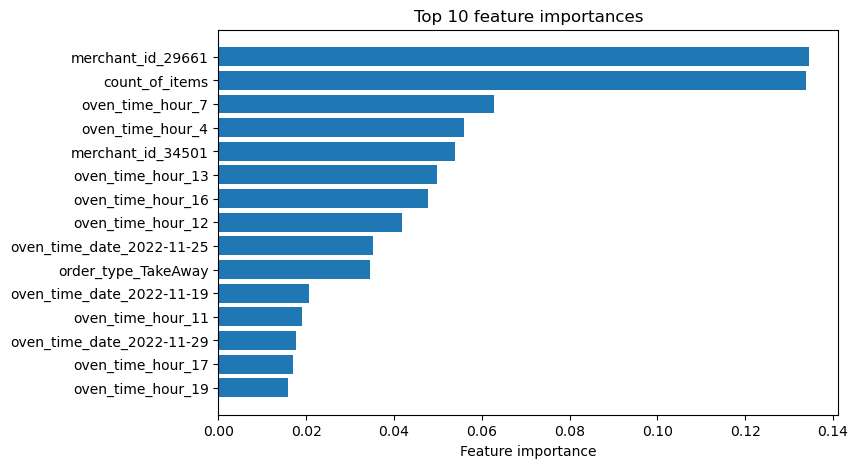

In [15]:
# set the random forest regressor and the cross validation
rfr = RandomForestRegressor(bootstrap=True,max_features='sqrt',random_state=1)
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# train the model
grid_search = GridSearchCV(rfr, param_grid, cv=cv)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# train the model with the best hyperparameters
rfr = RandomForestRegressor(**best_params, random_state=1)
rfr.fit(X_train, y_train)

# make predictions
y_pred_train = rfr.predict(X_train)
y_pred_test = rfr.predict(X_test)

# calculate the RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print('Best hyperparameters:', best_params)
print('RMSE of train data:', rmse_train)
print('RMSE of test data:', rmse_test)

# feature importance
importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1][:15]  # the top 15 features

# plot the feature importances of the forest
plt.figure(figsize=(8, 5))
plt.title("Top 10 feature importances")
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel("Feature importance")
plt.gca().invert_yaxis()
plt.show()

### Conclusions

Both the fixed effect and mixed effect models demonstrate that the hour of the day can predict the preparation time, with the most notable impact observed during the hours between 3am and 9am. It is worth noting that this impact is particularly significant, given the limited number of observations available during this time period.

Based on the RMSE metric, the difference in the performance of the models is not significant. The fixed effect model achieved the lowest RMSE on the test data, however, we decide to go with the mixed effect model since it takes into account the random effects of the stores and provides better model generalization.
The random forest model also performed well and could be considered as an alternative, especially if we are interested in predictive accuracy without the need for coefficient interpretation. However, the random forest model does not take into account the random effects of the stores and may not be as useful for identifying the factors that affect preparation time in a specific store.